# Segmentacja klientów

## Przygotowanie danych
Celem tego kroku jest przygotowanie danych tak, by podczas agregacji dla każdego z klientów zachować jak najwięcej informacji. Te dane pomogą w przeprowadzeniu segmentacji.

In [1]:
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from src.data import read_data, split_alcohol_column, aggregate_by_id
from src.visualization import plot_elbow

In [2]:
df = read_data('data/Dataset_Transaction.csv')
df = split_alcohol_column(df)
df.head()

CustomerId CustomerType CustomerChannel        CustomerStatus  \
0        1040  Spoza sieci      Restaurant  Obsługiwany przez PH   
1        1040  Spoza sieci      Restaurant  Obsługiwany przez PH   
2        1723         Sieć            Shop        Nieobsługiwany   
3        1040  Spoza sieci      Restaurant  Obsługiwany przez PH   
4        1040  Spoza sieci      Restaurant  Obsługiwany przez PH   

   CustomerLongitude  CustomerLatitude          ProductName TransactionDate  \
0          21.871591         50.529442       Rum Premium 88      2017-01-05   
1          21.871591         50.529442   Whisky Classic 372      2017-01-05   
2          15.758878         54.216344    Whisky Classic 50      2017-01-05   
3          21.871591         50.529442  Likier Standard 156      2017-01-05   
4          21.871591         50.529442  Likier Standard 160      2017-01-05   

   TransactionValue AlcoholName AlcoholClass AlcoholId  
0            431.91         Rum      Premium        88  
1           1549.85      Whisky      Classic       372  
2            555.15      Whisky      Classic        50  
3           1206.00      Likier     Standard       156  
4           1674.00      Likier     Standard       160

### Agregacja i one-hot encoding
Dane kategoryczne zostały przekształcone za pomocą metody [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). Następnie cały zbiór został zagregowany według `CustomerId`, co pozwoli na dokładniejszą analizę klientów, a nie niezależnych transakcji.

In [ ]:
aggregated = aggregate_by_id(df)
aggregated.head()

## Segmentacja

### Proste klastrowanie
Na początek wykorzystam tylko dwie kolumny - liczbę oraz sumę transakcji. Przed klastrowaniem dane muszą zostać znormalizowane oraz ustandaryzowane.

In [5]:
simple = aggregated[['TransactionCount', 'TransactionSum']]
simple = np.log(simple)
std_scaler = StandardScaler()
simple_scaled = std_scaler.fit_transform(simple)

By wybrać odpowiednią liczbę klastrów, skorzystam z [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

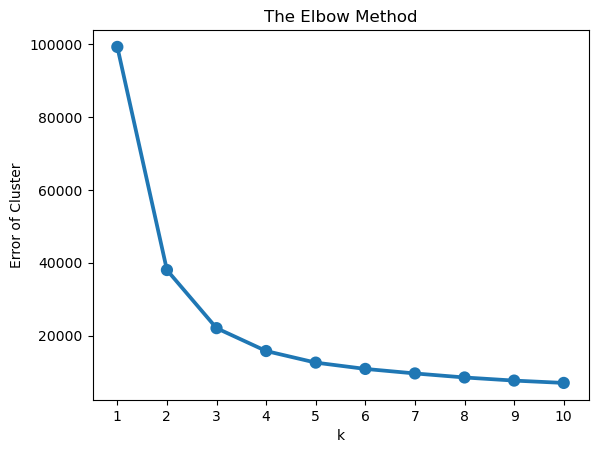

In [6]:
plot_elbow(simple_scaled)

Najlepsza liczba klastrów to 3.

In [88]:
model = KMeans(n_clusters=3, random_state=23)
model.fit(simple_scaled)
simple = simple.assign(ClusterLabel=model.labels_)
simple.groupby("ClusterLabel")[['TransactionCount', 'TransactionSum']].median()

TransactionCount  TransactionSum
ClusterLabel                                  
0                     3.465736        9.428992
1                     0.693147        6.225884
2                     2.197225        7.911359

In [101]:
simple = simple.astype({"ClusterLabel" : "category"})
fig = px.scatter(data_frame=simple, x="TransactionCount", y="TransactionSum",
    title="Relationship between number of transactions and transaction values", color="ClusterLabel")
fig.show()

Klienci zostali podzieleni według wydatków.

### Projekcja danych
By w grupowaniu wziąć pod uwagę więcej parametrów - skorzytam z metody [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).

In [141]:
df_std = std_scaler.fit_transform(aggregated)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_std)

### Klastrowanie
Ponownie korzystam z łokcia.

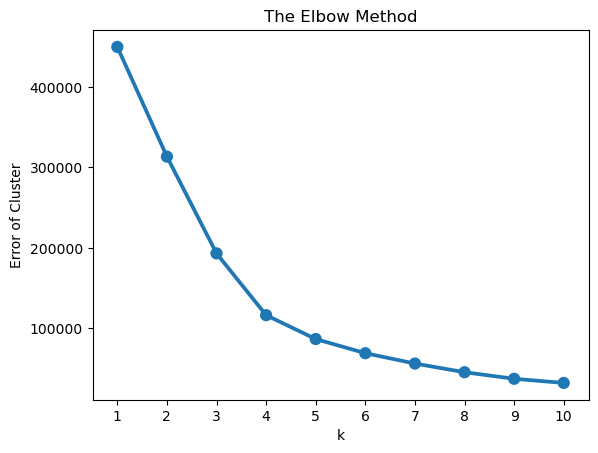

In [143]:
plot_elbow(df_pca)

Najkorzystniejsze będą 4 klastry.

In [144]:
model = KMeans(n_clusters=4, random_state=23)
model.fit(df_pca)
aggregated = aggregated.assign(ClusterLabel=model.labels_)
aggregated.groupby("ClusterLabel").median()

# TODO liczba pkt w danym klastrze

TransactionCount  TransactionSum  Sieć  Spoza sieci  Restaurant  \
ClusterLabel                                                                    
0                         10.0        2707.555   0.0          1.0         0.0   
1                          5.0        2107.290   0.0          1.0         1.0   
2                         77.0       33431.140   1.0          0.0         0.0   
3                       2179.0     1991315.450   0.0          1.0         1.0   

              Shop  Brandy   Gin  Koniak  Likier  Others    Rum  Szampan  \
ClusterLabel                                                               
0              1.0     0.0   0.0     0.0     0.0     0.0    0.0      0.0   
1              0.0     0.0   0.0     0.0     0.0     0.0    0.0      0.0   
2              1.0     0.0   2.0     0.0     3.0     1.0    5.0      4.0   
3              0.0    25.0  92.0    55.0    89.0   132.0  214.0      0.0   

              Tequila  Whisky  Wino  Wódka  
ClusterLabel                                
0                 0.0     3.0   0.0    5.0  
1                 0.0     1.0   0.0    1.0  
2                 0.0    29.0   0.0   25.0  
3                71.0  1301.0  60.0  140.0

Widać, że największe różnice między klastrami występują w statystykach transakcji. Liczby różnych kupowanych alkoholi nie wnoszą zbyt wiele informacji.

In [151]:
aggregated = aggregated.astype({"ClusterLabel": "category"})
fig = px.scatter(data_frame=df_pca, x=0, y=1, title="Clustered customers",
                 color=aggregated.ClusterLabel, labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

Wykres przedstawia klastry dla projekcji danych. Algorytm dobrze oddzielił wartość odstającą (klaster 3.)

## Dodatkowe pomysły
* zmapowanie współrzędnych geograficznych do województw - możliwa segmentacja demograficzna